## From Scratch Learning with Segmented Images

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# import the libraries as shown below

from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPool2D, Dropout, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
import numpy as np
import itertools

In [5]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '../data/dataset_original/'
val_path = '../data/dataset_original/'

In [6]:
num_classes = 4
input_shape = (224,224,3)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape =  (3, 224, 224)
    chanDim = 1

my_model= Sequential()
my_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
my_model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
my_model.add(MaxPool2D(pool_size = (2, 2)))

my_model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
my_model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
my_model.add(MaxPool2D(pool_size=(2, 2)))

my_model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
my_model.add(Conv2D(32, (3, 3), activation='relu',padding = 'Same', activity_regularizer=tf.keras.regularizers.l2(0.001)))
my_model.add(MaxPool2D(pool_size=(2, 2)))

my_model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
my_model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same', activity_regularizer=tf.keras.regularizers.l2(0.001)))
my_model.add(MaxPool2D(pool_size=(2, 2)))
my_model.add(Dropout(0.4))

my_model.add(Flatten())
my_model.add(Dense(1024, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.01)))
my_model.add(Dense(1024, activation='relu'))
my_model.add(Dropout(0.5))

my_model.add(Dense(num_classes, activation='softmax'))
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 64)        3

In [7]:
from keras.optimizers import Adam

opt = Adam(lr=0.0001,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0,  amsgrad=False)

In [8]:
# tell the model what cost and optimization method to use
my_model.compile(
  loss='categorical_crossentropy',
  optimizer = opt,
  metrics=['accuracy']
)

In [9]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale = 1./255,
                             rotation_range=10,
                             zoom_range = 0.2,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             shear_range = 0.2, 
                             vertical_flip=True,
                             validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [10]:
# Make sure you provide the same target size as initialied for the image size
training_set = datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 subset = "training",
                                                 class_mode = 'categorical')

Found 6418 images belonging to 4 classes.


In [11]:
test_set = datagen.flow_from_directory(val_path,
                                       target_size = (224, 224),
                                       batch_size = 32,
                                       shuffle = False,
                                       subset = "validation",
                                       class_mode = 'categorical')

Found 1604 images belonging to 4 classes.


In [12]:
# ReduceLROnPlateau - automatically set the LR if no change is detected
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                             patience = 3, 
                                             verbose = 1, 
                                             factor = 0.5, 
                                             min_lr = 0.00001)

In [13]:
# fit the model
# Run the cell. It will take some time to execute
model_history = my_model.fit(
  training_set,
  validation_data=test_set,
  epochs=50,
  callbacks = [learning_rate_reduction],
  steps_per_epoch = len(training_set),
  validation_steps = len(test_set)  
)

Epoch 1/50
201/201 [==============================] - 2406s 12s/step - loss: 1.3018 - accuracy: 0.3539 - val_loss: 1.0433 - val_accuracy: 0.5337
Epoch 2/50
201/201 [==============================] - 87s 432ms/step - loss: 0.9620 - accuracy: 0.5985 - val_loss: 1.2021 - val_accuracy: 0.5349
Epoch 3/50
201/201 [==============================] - 86s 430ms/step - loss: 0.7633 - accuracy: 0.7156 - val_loss: 1.0950 - val_accuracy: 0.5848
Epoch 4/50
201/201 [==============================] - 87s 433ms/step - loss: 0.6536 - accuracy: 0.7640 - val_loss: 0.9818 - val_accuracy: 0.6166
Epoch 5/50
201/201 [==============================] - 87s 431ms/step - loss: 0.6218 - accuracy: 0.7837 - val_loss: 1.0491 - val_accuracy: 0.6010
Epoch 6/50
201/201 [==============================] - 87s 431ms/step - loss: 0.5214 - accuracy: 0.8156 - val_loss: 1.0751 - val_accuracy: 0.5680
Epoch 7/50
201/201 [==============================] - 87s 432ms/step - loss: 0.4713 - accuracy: 0.8365 - val_loss: 0.9053 - val_ac

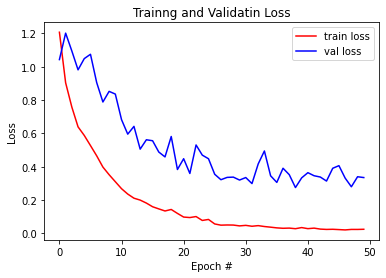

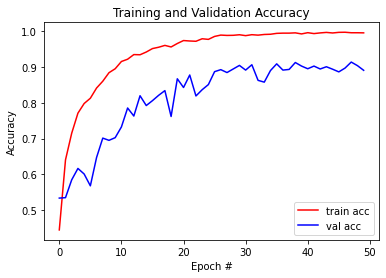

<Figure size 432x288 with 0 Axes>

In [14]:
# plot the loss
plt.plot(model_history.history['loss'],'r', label='train loss')
plt.plot(model_history.history['val_loss'],'b', label='val loss')
plt.title("Trainng and Validatin Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(model_history.history['accuracy'],'r', label='train acc')
plt.plot(model_history.history['val_accuracy'],'b', label='val acc')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [15]:
loss, accuracy = my_model.evaluate(test_set, verbose=1)
t_loss, t_accuracy = my_model.evaluate(training_set, verbose=1)

201/201 [==============================] - 69s 342ms/step - loss: 0.0164 - accuracy: 0.9989


In [22]:
print("Training: accuracy = %f  ;  loss_v = %f" % (t_accuracy, t_loss))
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Training: accuracy = 0.998909  ;  loss_v = 0.016428
Validation: accuracy = 0.901496  ;  loss = 0.330239


In [23]:
# save it as a h5 file

my_model.save('../models/faba_bean_model_4mScratch_original.h5')

In [18]:
# open saved model file

my_model = tf.keras.models.load_model('../models/faba_bean_model_4mScratch_original.h5')

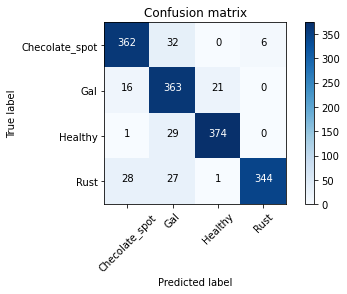

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Get the predicted classes
predictions = my_model.predict(test_set,  1604 // 32 + 1)
predicted_classes = np.argmax(predictions, axis = 1) 

# Get ground-truth classes and class-labels
true_classes = test_set.classes

target_name = ['Checolate_spot', 'Gal', 'Healthy', 'Rust']

confusion_mtx = confusion_matrix(true_classes, predicted_classes)

plot_confusion_matrix(confusion_mtx, classes = target_name) 

Text(0, 0.5, 'Fraction classified incorrectly')

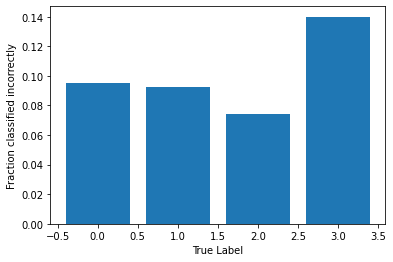

In [24]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(4),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

In [25]:
print('\nClassification Report\n')
class_labels = ['Checolate_spot', 'gal', 'healthy', 'rust']
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


Classification Report

                precision    recall  f1-score   support

Checolate_spot       0.89      0.91      0.90       400
           gal       0.80      0.91      0.85       400
       healthy       0.94      0.93      0.93       404
          rust       0.98      0.86      0.92       400

      accuracy                           0.90      1604
     macro avg       0.91      0.90      0.90      1604
  weighted avg       0.91      0.90      0.90      1604

